# Fixed-rate mortgage calculator

A simple mortgage calculator mainly written for my own purposes. It outputs payments, interest, principal, and optional overpayments. It's designed to be used in conjunction with the numbers provided by mortgage lenders, and some common sense.

- Bank of England base rate is only used to calculate the interest after the initial term. Initial rate should be input directly from numbers provided by lenders, which includes the current base rate.*
- The maximum overpayment is calculated as 10% of the remaining principal, and can be revealed by just passing a silly value like over_payment=999999999. It will calculate the max overpayment each month.

*You'd normally remortgage after the initial term anyway, but there is some utility in this because it shows the kind of interest you'd be facing after the initial term if the BoE base rate went up to 15% again.

In [24]:
def mortgage(principal, total_period, init_period, init_payment, init_rate, subs_rate, base_rate, over_payment):
    
    """
    Mortgage payment calculator. Returns dictionary of arrays
    
    principal: amount borrowed in arbitrary currency, e.g. 500000
    total_period: total mortgage duration in months
    init_period: initial term duration in months
    init_payment: initial monthly payment amount, e.g. 1205
    init_rate: initial interest rate expressed as a decimal. e.g. 0.0146 for 1.46%
    subs_rate: subsequent interest rate expressed as a decimal. e.g. 0.0376 for 3.76%
    base_rate: Bank of England base rate. e.g. 0.001 for 0.1%
    over_payment: optional fixed monthly overpayment
    """    
    
    # create arrays for plotting
    interest_values = []
    payment_values = []
    over_payment_values = []
    principal_values = []
    interest_cum_values = []
   
    # calculate initial max overpayment
    max_monthly_overpayment = principal*0.1*(1/12)
    
    # cumulative interest
    interest_cum = 0
    
    # payments for months of initial period
    for month in range(0, init_period):
        
        # update max available monthly overpayment each year
        if month % 12 == 0:
            max_monthly_overpayment = principal*0.1*(1/12)
            
        # calculate interest
        interest = principal*(1 + init_rate)**(1/12) - principal
        
        # add to interest for this month to total interest charged
        interest_cum += interest
    
        # add interest for current month
        principal += interest
     
        # subtract payment amount from principal
        if principal < init_payment:
            principal -= principal
            #stop payments if principal paid off
            init_payment=0 
            subs_payment=0
            over_payment=0
        else:
            principal -= init_payment       
            
        # subtract overpayment from principal
        if over_payment > max_monthly_overpayment:
            over_payment = max_monthly_overpayment

            if principal < over_payment:
                principal -= principal
                init_payment=0 
                subs_payment=0
                over_payment=0
            else:
                principal -= over_payment
        else:
            if principal < over_payment:
                principal -= principal
                init_payment=0 
                subs_payment=0
                over_payment=0
            else:
                principal -= over_payment
   
        # populate arrays for plotting
        interest_values.append(interest)
        interest_cum_values.append(interest_cum)
        payment_values.append(init_payment)
        over_payment_values.append(over_payment)
        principal_values.append(principal)
   
    # calculate payments for remaining balance at new rate
    subs_payment = ((((subs_rate+base_rate)/12))*((1+((subs_rate+base_rate)/12))**(total_period-init_period)) / (((1+((subs_rate+base_rate)/12))**(total_period-init_period)) - 1))*(principal)
    
    # payments for subsequent months
    for month in range(init_period, total_period):
        
        # interest added
        interest = principal*(1 + (subs_rate+base_rate))**(1/12) - principal
        
        # add to cumulative interest 
        interest_cum += interest
            
        # add interest for current month
        principal += interest
    
        # subtract (minimum) payment amount from principal
        if principal < subs_payment:
            principal -= principal
            #stop payments if principal paid off
            init_payment=0 
            subs_payment=0
            over_payment=0
        else:
            principal -= subs_payment
            
        # subtract overpayment amount from principal
        if principal < over_payment:
            principal -= principal
            #stop payments if principal paid off
            init_payment=0 
            subs_payment=0
            over_payment=0

        else:
            principal -= over_payment
        
        # populate arrays for plotting
        interest_values.append(interest)
        interest_cum_values.append(interest_cum)
        payment_values.append(subs_payment)
        over_payment_values.append(over_payment)
        principal_values.append(principal)
        
    results = dict.fromkeys(['Interest', 'Payments', 'Overpayments', 'Principal'])
    results['Interest'] = interest_values
    results['Payments'] = payment_values
    results['Overpayments'] = over_payment_values
    results['Principal'] = principal_values
    
    return results

In [48]:
m = mortgage(principal=200000,
             total_period=25*12,
             init_period=5*12+3,
             init_payment=747.14,
             init_rate=0.0286,
             subs_rate=0.0449,
             base_rate=0.1,
             over_payment=100
            )

In [49]:
import pandas as pd

df = pd.DataFrame()

df['principal'] = m['Principal']
df['interest'] = m['Interest']
df['payments'] = m['Payments']
df['overpayments'] = m['Overpayments']

In [50]:
df

,principal,interest,payments,overpayments
0,199623.390203,470.530203,747.14,100
1,199245.894374,469.644171,747.14,100
2,198867.510429,468.756055,747.14,100
3,198488.236279,467.865850,747.14,100
4,198108.069830,466.973550,747.14,100
...,...,...,...,...
295,0.000000,0.000000,0.00,0
296,0.000000,0.000000,0.00,0
297,0.000000,0.000000,0.00,0
298,0.000000,0.000000,0.00,0


Text(0, 0.5, 'amount / £')

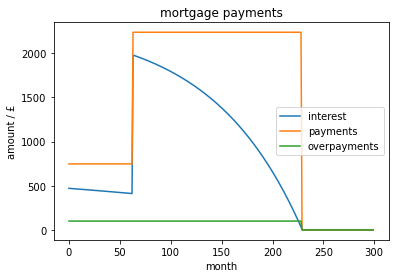

In [64]:
#plt.plot(df.index, df['principal'])
plt.plot(df.index, df['interest'], label='interest')
plt.plot(df.index, df['payments'], label='payments')
plt.plot(df.index, df['overpayments'], label='overpayments')
plt.legend(loc='best')
plt.title('mortgage payments')
plt.xlabel('month')
plt.ylabel('amount / £')